In [1]:
import pandas as pd
import sklearn
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string

# allow display of multiple outputs by running one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



C:\Users\fatma\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\fatma\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\fatma\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data = pd.read_csv('Data/final_data.csv')
data.head()


,id,location,tweetcreatedts,text,class
0,0,"Michigan, USA",2021-02-06 04:50:59+00:00,"RT @shecolem: Im not doing okay, no I dont wan...",anxiety
1,1,NaN,2021-02-03 23:59:29+00:00,RT @imjustinrandall: James Corden acts gay for...,stress
2,2,she/her,2021-01-27 23:59:30+00:00,Sick and tired\nBut I don't wanna mess up\n'Ca...,stress
3,3,she her,2021-02-07 02:25:56+00:00,Very time sensitive. I'm trans and my roommate...,anxiety
4,4,"Ventura, CA",2021-02-12 19:21:20+00:00,still one of my favorite plays of all time htt...,normal


In [3]:
#find duplicate rows across all columns
print('Number of the duplicated rows= ',data.duplicated().sum())

# summary of the number of nulls
print('Total missing values = ', data.isna().sum().sum())

print('Number of nulls in each column:')
data.isna().sum()
print('________________________________________________________________')

# count the ratio of missing values
total_miss = data.isnull().sum()
percent_miss = (total_miss/data.isnull().count()*100)

# sort attributes by missing value ratio
missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
missing_data.sort_values(by='Total missing',ascending=False)

Number of the duplicated rows=  0
Total missing values =  10140
Number of nulls in each column:


id                    0
location          10140
tweetcreatedts        0
text                  0
class                 0
dtype: int64

________________________________________________________________


,Total missing,% missing
location,10140,32.493751
id,0,0.000000
tweetcreatedts,0,0.000000
text,0,0.000000
class,0,0.000000


In [6]:
data['class'].value_counts()

anxiety    12585
normal     10022
stress      8599
Name: class, dtype: int64

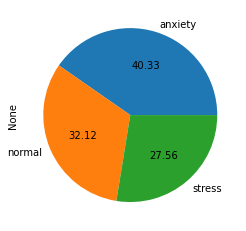

In [7]:
data.groupby('class').size().plot(kind='pie', autopct='%.2f')

In [8]:
# let's use standard english stop-words first, later we would see if we need to filter specific stopwords (high-frequent words with no discriminative power)
cachedStopWords = list(esw)
lemmatizer=WordNetLemmatizer()
#ps = PorterStemmer()

def lemmatize_article(sentence):
    sentence = word_tokenize(sentence)
    res = ''
    for word, tag in pos_tag(sentence):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        word = lemmatizer.lemmatize(word, wntag) if wntag else word
        res += word + ' '
    return res
    
def remove_stop_words(sentence):
    return ' '.join([word for word in sentence.split() if word not in cachedStopWords])
    
def remove_short(sentence):
    return ' '.join([word for word in sentence.split() if len(word) >= 3])
    
def remove_digits(sentence):
    return ' '.join([i for i in sentence.split() if not i.isdigit()])
    
def preprocess(all_texts):
    all_texts = list(map(lambda x: x.lower(), all_texts))
    all_texts = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), all_texts))
    all_texts = list(map(lambda x: lemmatize_article(x), all_texts))
    all_texts = list(map(lambda x: x.strip(), all_texts))
    all_texts = list(map(lambda x: remove_stop_words(x), all_texts))
    all_texts = list(map(lambda x: remove_short(x), all_texts))
    all_texts = list(map(lambda x: remove_digits(x), all_texts))
    return all_texts
    

In [9]:
# preprocess text
data['text_cleaned'] = preprocess(data['text'])
data

,id,location,tweetcreatedts,text,class,text_cleaned
0,0,"Michigan, USA",2021-02-06 04:50:59+00:00,"RT @shecolem: Im not doing okay, no I dont wan...",anxiety,shecolem okay dont want talk emotionally avail...
1,1,NaN,2021-02-03 23:59:29+00:00,RT @imjustinrandall: James Corden acts gay for...,stress,imjustinrandall james corden act gay hour gold...
2,2,she/her,2021-01-27 23:59:30+00:00,Sick and tired\nBut I don't wanna mess up\n'Ca...,stress,sick tire dont wan mess cause life
3,3,she her,2021-02-07 02:25:56+00:00,Very time sensitive. I'm trans and my roommate...,anxiety,time sensitive trans roommate today literally ...
4,4,"Ventura, CA",2021-02-12 19:21:20+00:00,still one of my favorite plays of all time htt...,normal,favorite play time httpstcoy4whkhknbl
...,...,...,...,...,...,...
31201,31201,swag,2021-02-12 20:07:13+00:00,i didn't unfollow :( my account is broken sorry,normal,didnt unfollow account break sorry
31202,31202,#abuja,2021-02-05 07:37:54+00:00,Please I need a job ! Just lost my job! Anybo...,anxiety,need job just lose job anybody somebody help w...
31203,31203,Love yourself❤️,2021-02-12 19:46:42+00:00,RT @6LACK: im one of a kind couldnt fake my love,normal,6lack kind fake love
31204,31204,Puerto Rico,2021-02-12 19:46:42+00:00,@stacie_b_ HES JUST SO HHHHHH. I CANT LIVE MY ...,normal,stacieb just hhhhhh live life pretend doesnt a...


<Figure size 2880x4320 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'normal')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'anxiety')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'stress')

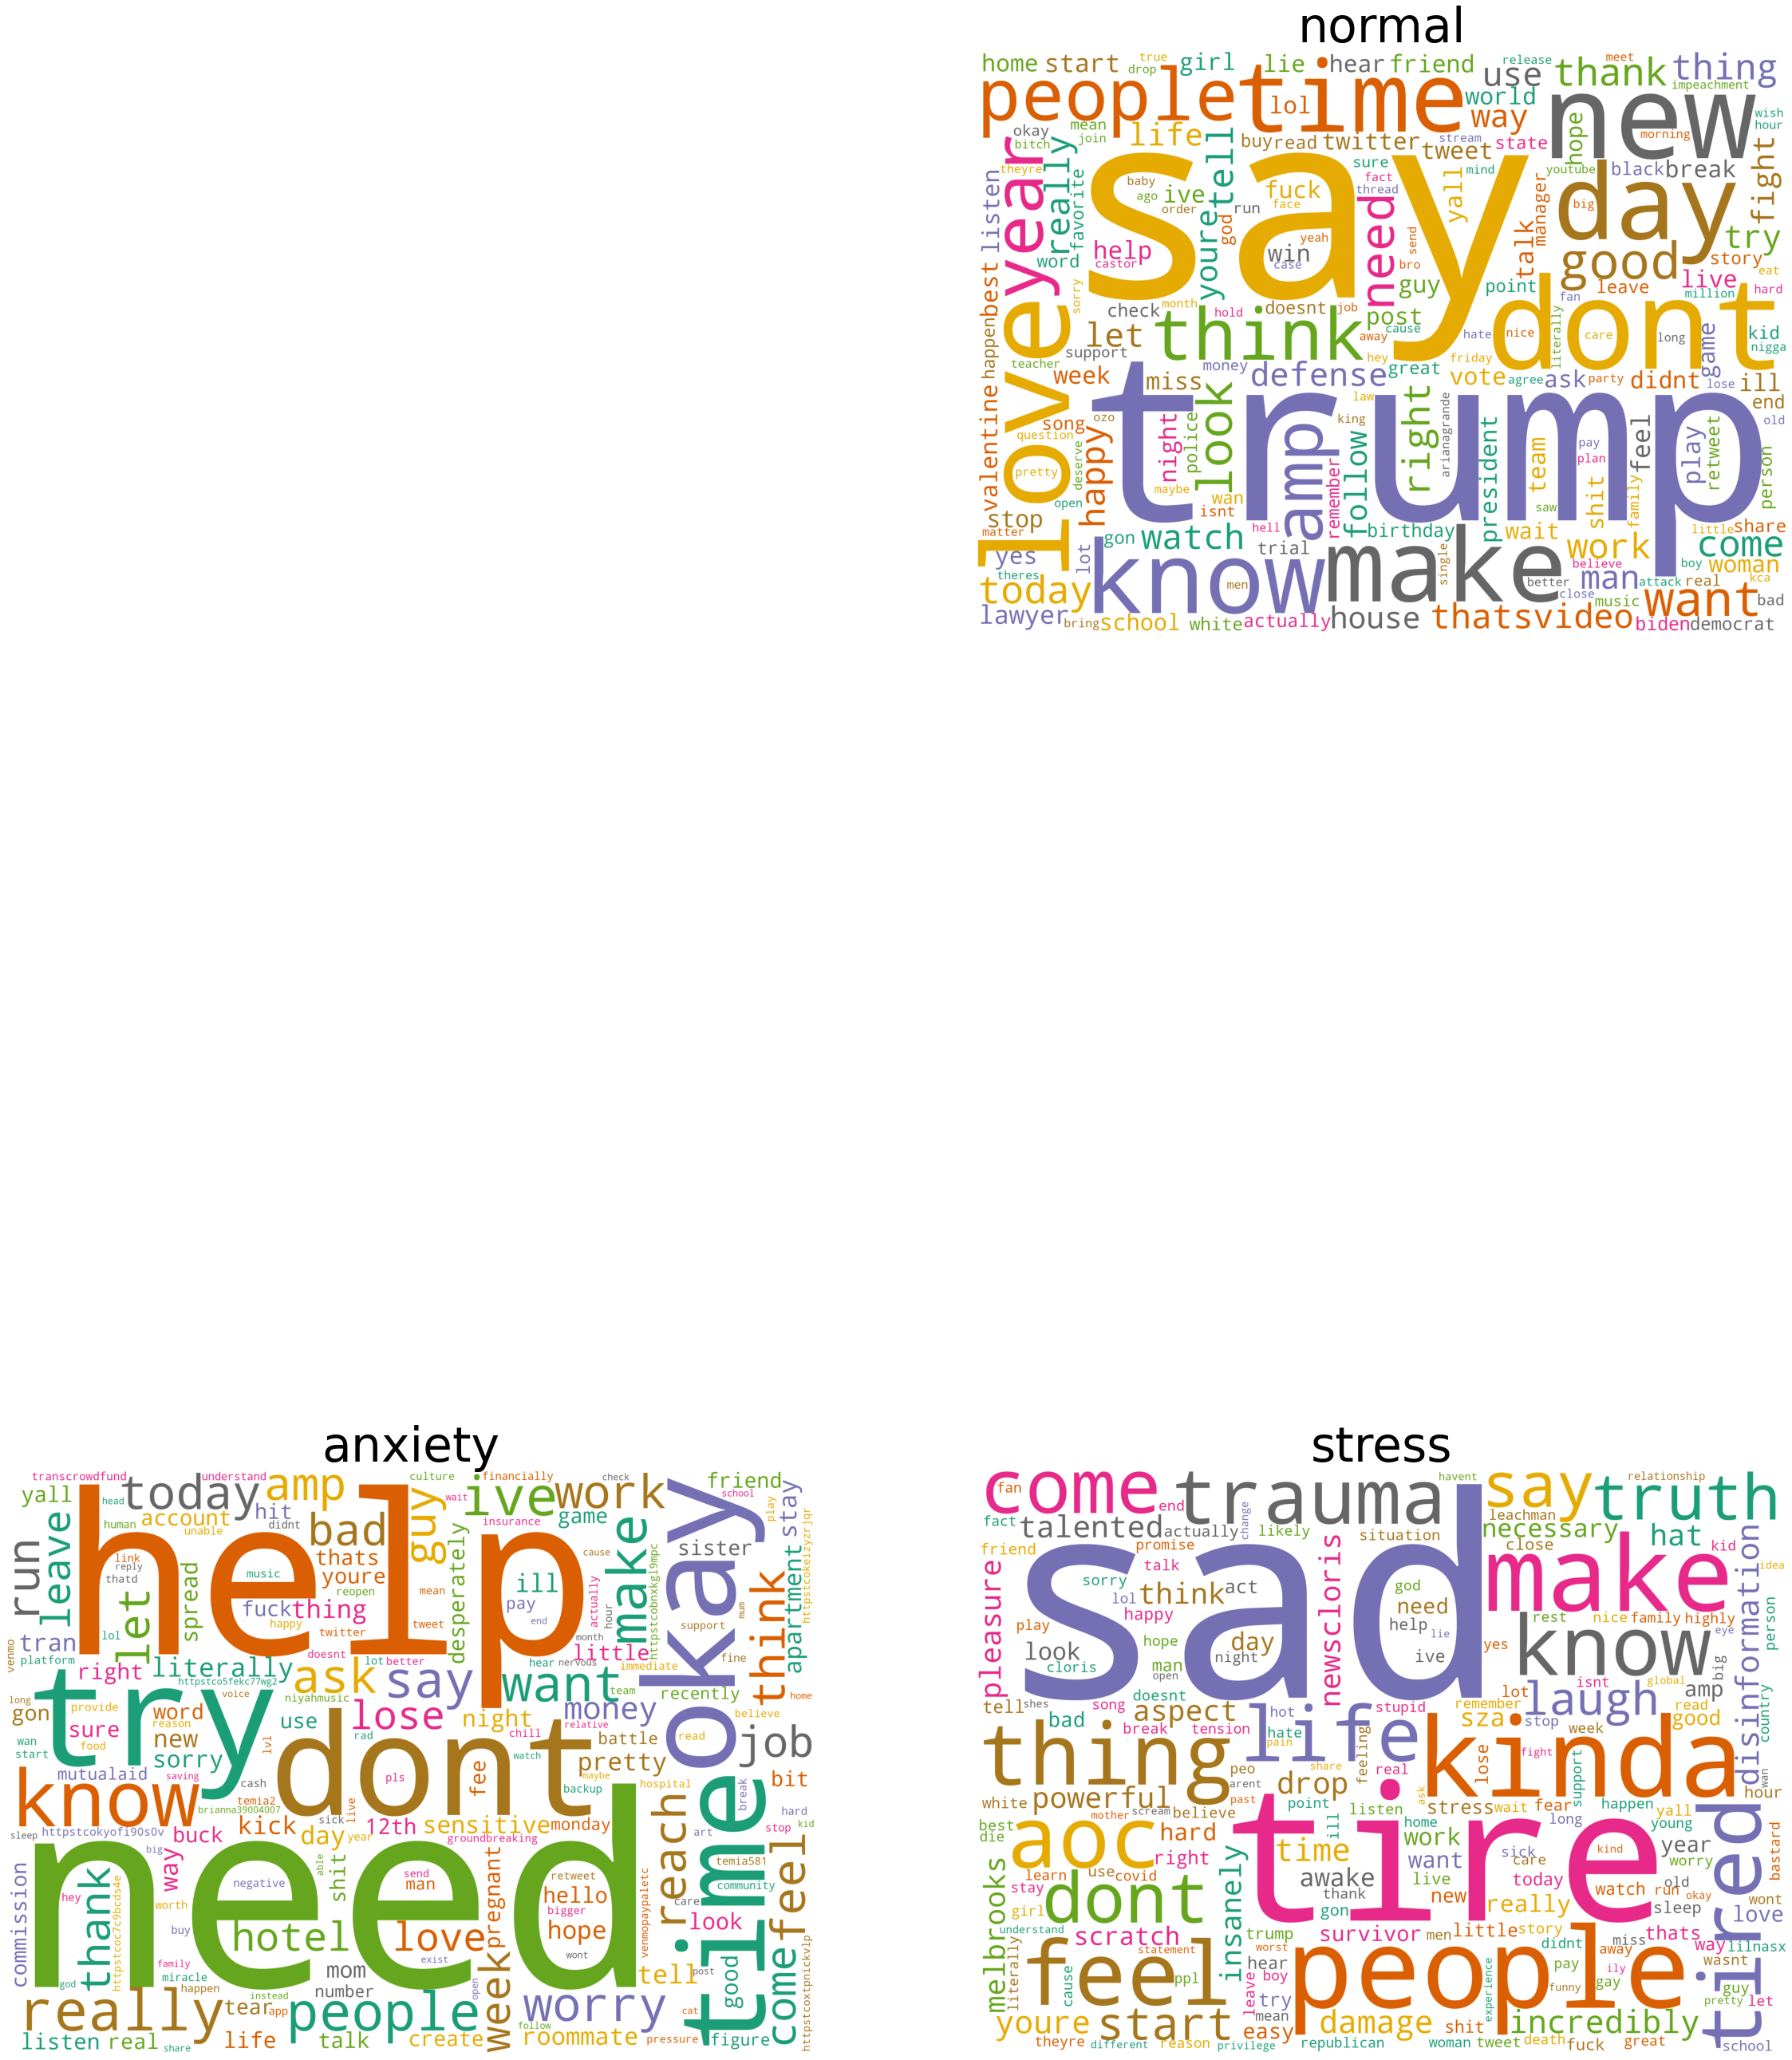

In [12]:
from wordcloud import WordCloud,STOPWORDS


plt.figure(figsize=(40,60))
# subset = data[data['class']=='lonely']
# text_cleaned = subset.text_cleaned.values
# cloud1=WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

# plt.subplot(2,2,1)
# plt.axis('off')
# plt.title("lonely",fontsize=60)
# plt.imshow(cloud1)


subset = data[data['class']=='normal']
text_cleaned = subset.text_cleaned.values
cloud2 = WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,2)
plt.axis('off')
plt.title("normal",fontsize=60)
plt.imshow(cloud2)

subset = data[data['class']=='anxiety']
text_cleaned = subset.text_cleaned.values
cloud3 = WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,3)
plt.axis('off')
plt.title("anxiety",fontsize=60)
plt.imshow(cloud3)


subset = data[data['class']=='stress']
text_cleaned = subset.text_cleaned.values
cloud4 = WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,4)
plt.axis('off')
plt.title("stress",fontsize=60)
plt.imshow(cloud4)


In [ ]:
# word2vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
 
warnings.filterwarnings(action = 'ignore')
 
import gensim
from gensim.models import Word2Vec
 
data = []
 


# tokenize the sentence into words
for j in word_tokenize(X):
    data.append(j.lower())

# data.append(temp)

# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count = 1,
                              vector_size = 100, window = 5)
 
# Print results
print("Cosine similarity between 'alice' " +
               "and 'wonderland' - CBOW : ",
    model1.wv.similarity('alice', 'wonderland'))
     
print("Cosine similarity between 'alice' " +
                 "and 'machines' - CBOW : ",
      model1.wv.similarity('alice', 'machines'))
 
# Create Skip Gram model
model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100,
                                             window = 5, sg = 1)
 
# Print results
print("Cosine similarity between 'alice' " +
          "and 'wonderland' - Skip Gram : ",
    model2.wv.similarity('alice', 'wonderland'))
     
print("Cosine similarity between 'alice' " +
            "and 'machines' - Skip Gram : ",
      model2.wv.similarity('alice', 'machines'))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
